# Анализ результатов эксперимента от 29.08.25

In [1]:
%load_ext autoreload
%autoreload 2

## Описание эксперимента

Использовался алгоритм TD3 (Twin Delayed DDPG), адаптированный для работы в реальном времени в среде с бесконечным горизонтом. Состояние системы $s$ описывалось значениями с АЦП (управляемый сигнал) и ЦАП (управляющий сигнал), а также заданным для поддержания значением. Действие $a$ агента представляло собой выбор коэффициентов ПИД-регулятора $(K_p, K_i, K_d)$, а награда $r$ определялась по формуле
$$
r = -\left\lvert U_\text{setpoint} - U_\text{process variable} \right\rvert,
$$
где $U_\text{setpoint}$ — установленное значение, а $U_\text{process variable}$ - сигнал с АЦП.

Для корректной работы в реальном времени процесс сбора данных (взаимодействие агента с системой и формирование буфера переходов) и процесс обучения (обновления Q-функций и политики) были разделены.

## Результаты

In [2]:
from pathlib import Path

EXPERIMENT_NAME = "td3_train_real_async"
EXPERIMENT_DATE = "2025-08-29"
EXPERIMENT_TIME = "19-46-18"

PATH_TO_EXP_DIR = Path(f"../experiments/{EXPERIMENT_NAME}/{EXPERIMENT_DATE}/{EXPERIMENT_TIME}")

LOG_TRAIN_DIR = PATH_TO_EXP_DIR / "train_logs"
LOG_ENV_DIR = PATH_TO_EXP_DIR / "env_logs"

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tensorboard_df(ax, df, tags=None, title="Training curves"):
    for tag in tags:
        sns.lineplot(data=df, x="step", y=tag, ax=ax, label=tag)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Step")
    ax.set_ylabel("Value")
    ax.legend(title="Metric")

In [4]:
from nn_laser_stabilizer.utils import tensorboard_to_df

train_df = tensorboard_to_df(str(LOG_TRAIN_DIR))

env_df = tensorboard_to_df(str(LOG_ENV_DIR))
env_df["Reward"] = -abs(env_df["Observation/x"] - env_df["Observation/setpoint"]) + 1

Tensorboard содержит не все данные: количество step значительно количества точек.

In [19]:
print(env_df.info())
print(env_df["step"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  10000 non-null  int64  
 1   Action/kd             10000 non-null  float64
 2   Action/ki             10000 non-null  float64
 3   Action/kp             10000 non-null  float64
 4   Observation/setpoint  10000 non-null  float64
 5   Observation/x         10000 non-null  float64
 6   Reward                10000 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 547.0 KB
None
0           16
1           56
2           66
3           72
4           81
         ...  
9995    409391
9996    409398
9997    409439
9998    409458
9999    409633
Name: step, Length: 10000, dtype: int64


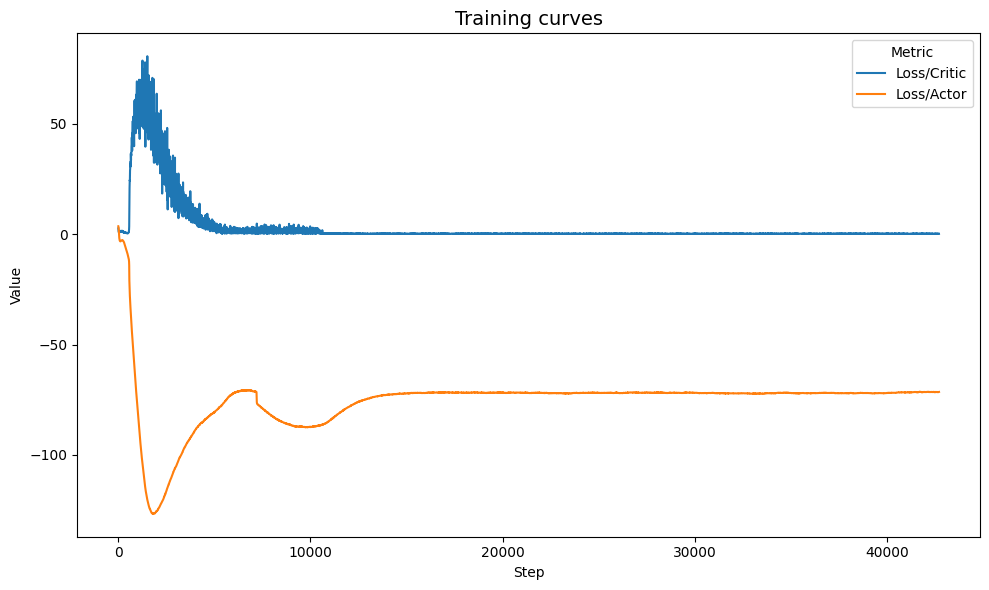

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_tensorboard_df(ax, train_df, tags=["Loss/Critic", "Loss/Actor"], title="Training curves")
plt.tight_layout()
plt.savefig(LOG_TRAIN_DIR / "train_logs.pdf")

In [6]:
ADC_MAX = 10230

# Делаем обратное преобразование для графика
env_df["Observation/x"] = ((env_df["Observation/x"] + 1) / 2) * ADC_MAX
env_df["Observation/setpoint"] = ((env_df["Observation/setpoint"] + 1) / 2) * ADC_MAX

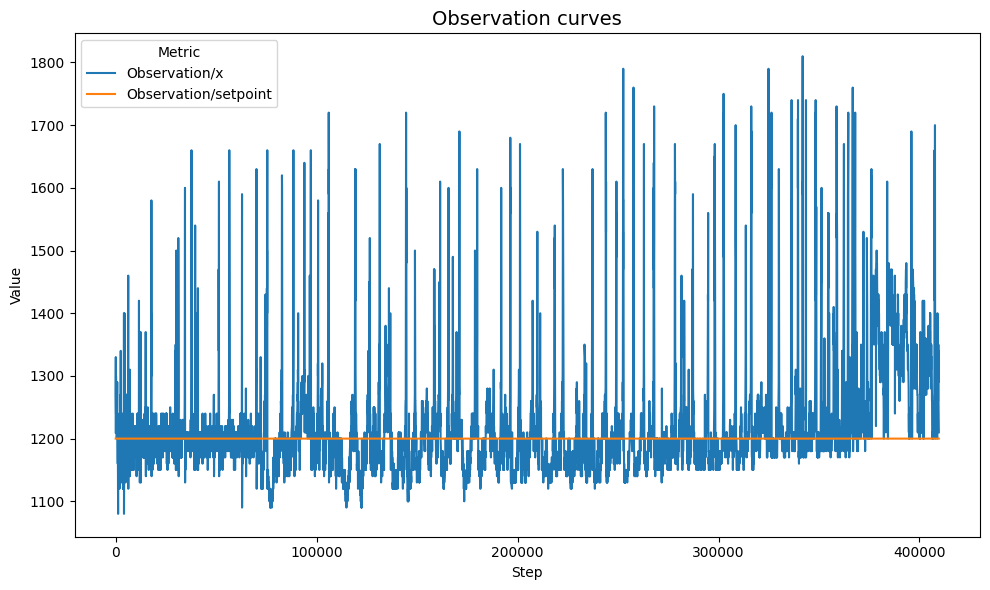

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_tensorboard_df(ax, env_df, tags=["Observation/x", "Observation/setpoint"], title="Observation curves")
plt.tight_layout()
plt.savefig(LOG_ENV_DIR / "observation_logs.pdf")

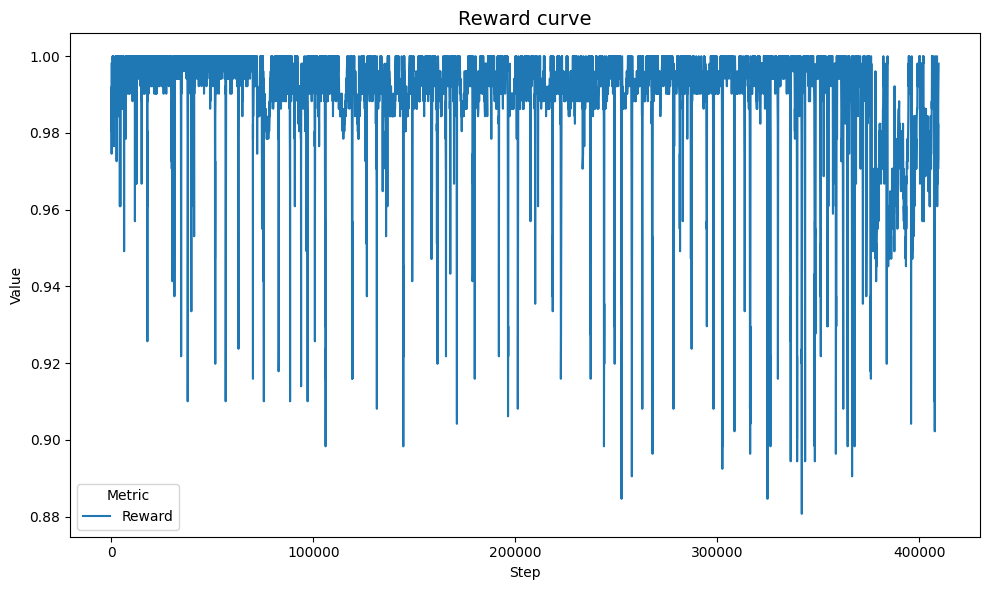

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_tensorboard_df(ax, env_df, tags=["Reward"], title="Reward curve")
plt.tight_layout()
plt.savefig(LOG_ENV_DIR / "reward_logs.pdf")

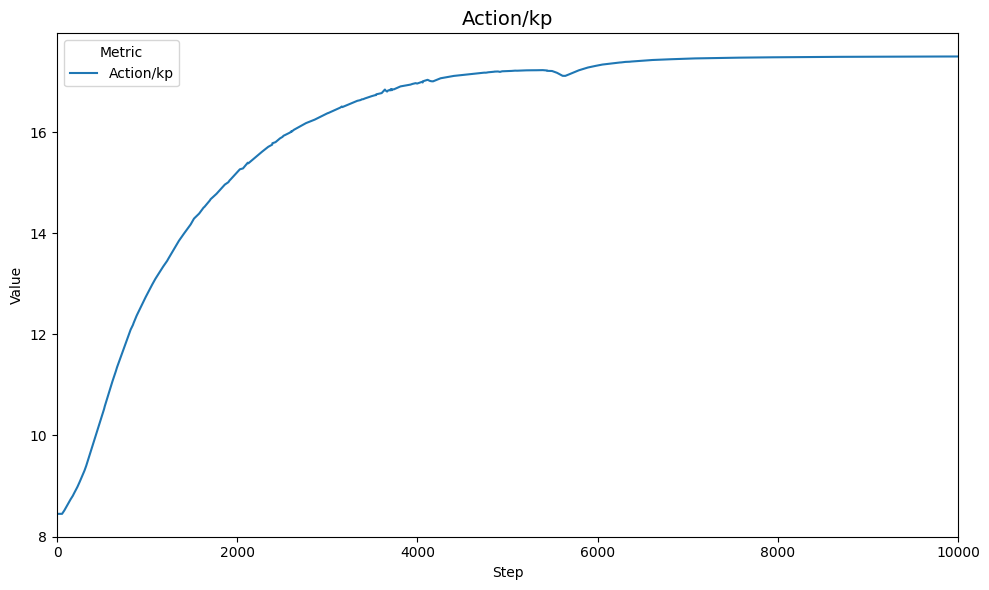

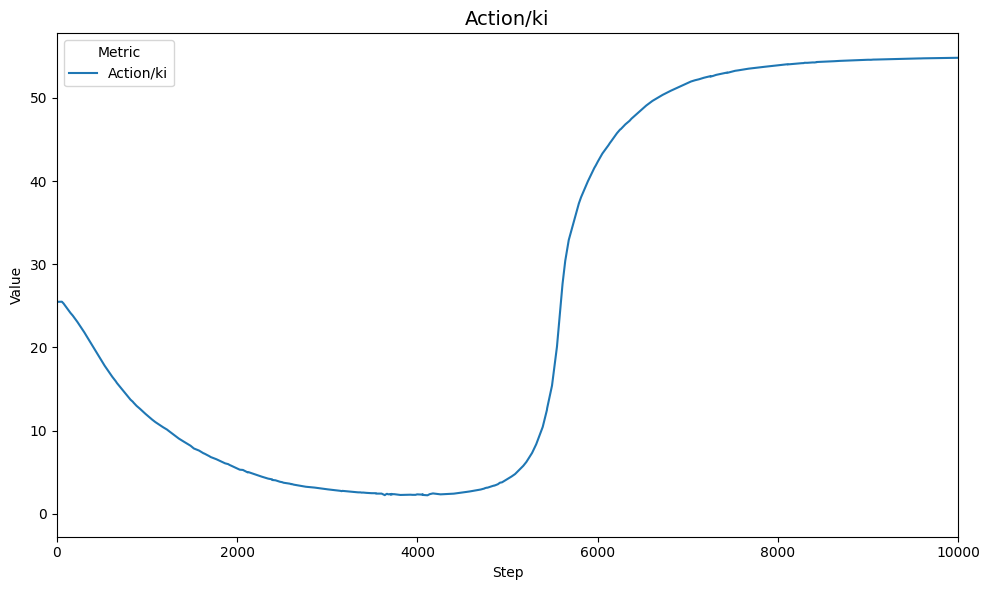

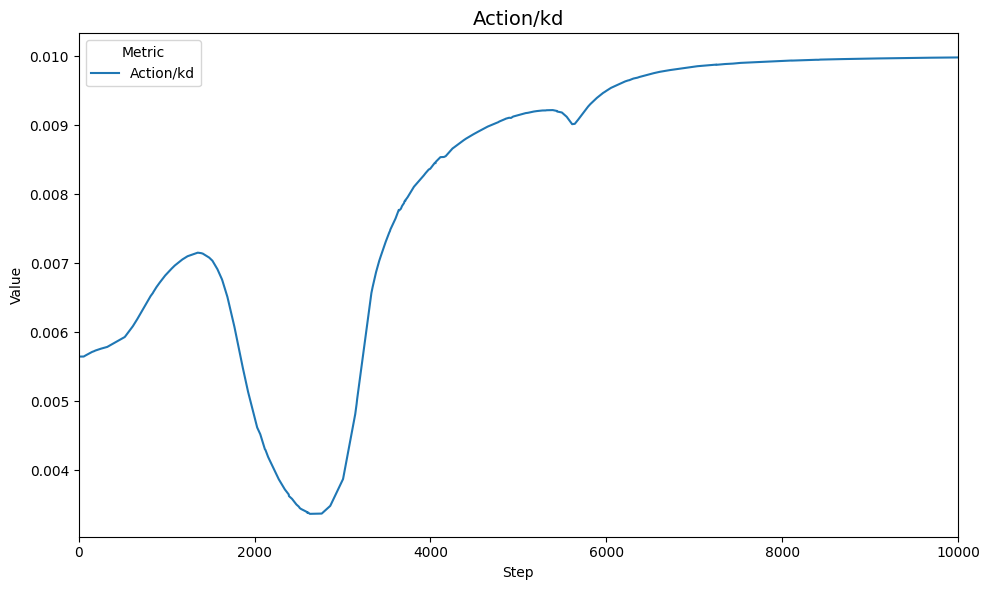

In [9]:
action_tags = ["Action/kp", "Action/ki", "Action/kd"]

for tag in action_tags:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 10000)

    plot_tensorboard_df(ax, env_df, tags=[tag], title=tag)

    plt.tight_layout()
    plt.savefig(LOG_ENV_DIR / f"{tag.replace('/', '_')}_first_steps.pdf")